In [203]:
#!conda install --yes -c conda-forge cufflinks-py

# Introduction

Bitcoin (BTC) is proposed to provided a modern era store of value and be a potential successor to Gold (GLD) in this respect (Ammous, 2018). Ammous (2018) illustrates that one of the key determinate factors of both BTC and GLD in confering this property is that they both demonstrate a high stock-to-flow ratio.

Stock-to-flow refers to the property by which the current global stock or holding of an asset compares to the potential incomming flow of that asset. For example, the global stock of GLD compared to the potential new production of GLD is very high - i.e. its a rare metal on Earth and the effort of extraction of new GLD only accounts for some 2% of the stock. This is compared to the potential stock-to-flow of fiat currency whereby government issued paper (no longer backed by anything like a gold standard) can be printed / minted readily (with little effort) thus large quantities of new flow can devalue currently held stock, leading to inflationary periods and the consequent socio-economic results. The economic model of BTC is purported to resemble that of GLD as BTC miners are effectively expending a larger amount of resource and effort in minting new Bitcions. In addition the total global supply of BTC is capped to 22 million; this should result in a deflationary currency.

In this study this notebook will:

1. Investigate the potential correlation between BTC and GLD returns in timeseries, assuming a positive correlation indicates some representation whereby BTC is also considered a store of value.
2. Machine learning will be applied to determine if the trades into BTC or GLD can be recommended (it is suspected that the recent activities driving the price of BTC higher could result in an extremely simple, hold only strategy)



In [291]:
# import libraries

import os
import pandas as pd
import numpy as np
import time

import cufflinks as cf
import plotly.offline as plyo
#pd.options.plotting.backend = "plotly"
cf.go_offline()

from pylab import mpl, plt
plt.style.use('seaborn')
%matplotlib inline

# libraries for analysis with GPU

#import cupy as cp
#import cudf
#import dask_cudf

The project does not require a full Extract Transform Load (ETL) pipeline, we do however need to extract and potentially clean the data after a period of discovery. The extraction and initial analysis of daily BTC (from the exchange Binance (2021) follows).

In [292]:

df_BTC_USD_daily = pd.read_csv('crypto_data/Binance_BTCUSDT_d.csv', skiprows=1)

In [293]:
df_BTC_USD_daily.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.611187e+12,2021-01-21 00:00:00,BTC/USDT,35468.23,35600.00,35304.63,35319.06,307.752511,1.091121e+07,10161.0
1,1.611101e+12,2021-01-20 00:00:00,BTC/USDT,35901.94,36415.31,33400.00,35468.23,89368.422918,3.126721e+09,2234539.0
2,1.611014e+12,2021-01-19 00:00:00,BTC/USDT,36622.46,37850.00,35844.06,35891.49,79611.307769,2.935348e+09,1939371.0
3,1.610928e+12,2021-01-18 00:00:00,BTC/USDT,35824.99,37469.83,34800.00,36631.27,70698.118750,2.554843e+09,1707766.0
4,1.610842e+12,2021-01-17 00:00:00,BTC/USDT,35994.98,36852.50,33850.00,35828.61,80157.727384,2.843103e+09,1860642.0


In [294]:
df_BTC_USD_daily.describe()

,unix,open,high,low,close,Volume BTC,Volume USDT,tradecount
count,1.255000e+03,1255.000000,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03,1.131000e+03
mean,1.408150e+12,8997.216932,9271.379044,8686.398733,9021.788510,45626.800031,4.717578e+08,5.154053e+05
std,4.667163e+11,5081.027649,5312.224687,4807.335260,5133.340739,34889.453619,6.460202e+08,4.662954e+05
min,1.502928e+09,3189.020000,3276.500000,2817.000000,3189.020000,225.760000,9.677533e+05,1.016100e+04
25%,1.529928e+12,6391.540000,6537.500000,6260.500000,6393.135000,25434.349423,1.708942e+08,2.159290e+05
50%,1.557014e+12,8184.970000,8382.800000,7954.000000,8187.170000,38896.639746,3.073169e+08,3.573820e+05
75%,1.584101e+12,10235.730000,10455.000000,9900.000000,10242.875000,59211.513017,5.189953e+08,6.468370e+05
max,1.611187e+12,40586.960000,41950.000000,38720.000000,40582.810000,402201.673764,8.426880e+09,4.431451e+06


In [295]:
df_BTC_USD_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unix         1255 non-null   float64
 1   date         1255 non-null   object 
 2   symbol       1255 non-null   object 
 3   open         1255 non-null   float64
 4   high         1255 non-null   float64
 5   low          1255 non-null   float64
 6   close        1255 non-null   float64
 7   Volume BTC   1255 non-null   float64
 8   Volume USDT  1255 non-null   float64
 9   tradecount   1131 non-null   float64
dtypes: float64(8), object(2)
memory usage: 98.2+ KB


It appears that there are some missing trade count values though other values seem ok.

In [296]:
df_BTC_USD_daily.isna().sum()

unix             0
date             0
symbol           0
open             0
high             0
low              0
close            0
Volume BTC       0
Volume USDT      0
tradecount     124
dtype: int64

It appears that there are null values for trade count. Upon inspection it seems that the missing values for trade count occur near the start of the data, assuming that Binance where not publishing these values during this time period.
TODO: ensure that the tradecounts are only for early data
TODO: can fill with the average, is it useful?

In [298]:
df_BTC_USD_daily[df_BTC_USD_daily['tradecount'].isna()]

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
1131,1.513555e+09,2017-12-18,BTC/USDT,18860.02,19300.00,17029.98,18856.25,10280.98,1.900573e+08,NaN
1132,1.513469e+09,2017-12-17,BTC/USDT,19102.66,19798.68,18510.00,18860.02,8980.73,1.721134e+08,NaN
1133,1.513382e+09,2017-12-16,BTC/USDT,17539.83,19539.00,17190.01,19102.66,4118.28,7.473658e+07,NaN
1134,1.513296e+09,2017-12-15,BTC/USDT,16334.98,17991.00,16298.45,17539.83,8999.13,1.566451e+08,NaN
1135,1.513210e+09,2017-12-14,BTC/USDT,16033.29,16445.00,15450.00,16334.98,11220.26,1.797144e+08,NaN
...,...,...,...,...,...,...,...,...,...,...
1250,1.503274e+09,2017-08-21,BTC/USDT,4086.29,4119.62,3911.79,4016.00,685.12,2.770592e+06,NaN
1251,1.503187e+09,2017-08-20,BTC/USDT,4139.98,4211.08,4032.62,4086.29,463.54,1.915636e+06,NaN
1252,1.503101e+09,2017-08-19,BTC/USDT,4108.37,4184.69,3850.00,4139.98,371.15,1.508239e+06,NaN
1253,1.503014e+09,2017-08-18,BTC/USDT,4285.08,4371.52,3938.77,4108.37,1178.07,4.994494e+06,NaN


We can now see that the data is daily Open, Low, High, Close (OLHC) with associated Volumes and Tradecounts. We can further visualise and analyse this data if we treat it like true timeseries data in Pandas. We can also note that first column (index_col=0), whilst representing the timeseries is a unix epoch time, we therefore reimport the data using 

In [211]:
df_BTC_USD_daily = pd.read_csv('crypto_data/Binance_BTCUSDT_d.csv', skiprows=1, index_col=1, parse_dates=True)

In [212]:
df_BTC_USD_daily

,unix,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
date,,,,,,,,,
2021-01-21,1.611187e+12,BTC/USDT,35468.23,35600.00,35304.63,35319.06,307.752511,1.091121e+07,10161.0
2021-01-20,1.611101e+12,BTC/USDT,35901.94,36415.31,33400.00,35468.23,89368.422918,3.126721e+09,2234539.0
2021-01-19,1.611014e+12,BTC/USDT,36622.46,37850.00,35844.06,35891.49,79611.307769,2.935348e+09,1939371.0
2021-01-18,1.610928e+12,BTC/USDT,35824.99,37469.83,34800.00,36631.27,70698.118750,2.554843e+09,1707766.0
2021-01-17,1.610842e+12,BTC/USDT,35994.98,36852.50,33850.00,35828.61,80157.727384,2.843103e+09,1860642.0
...,...,...,...,...,...,...,...,...,...
2017-08-21,1.503274e+09,BTC/USDT,4086.29,4119.62,3911.79,4016.00,685.120000,2.770592e+06,NaN
2017-08-20,1.503187e+09,BTC/USDT,4139.98,4211.08,4032.62,4086.29,463.540000,1.915636e+06,NaN
2017-08-19,1.503101e+09,BTC/USDT,4108.37,4184.69,3850.00,4139.98,371.150000,1.508239e+06,NaN


In [213]:
df_olhc = df_BTC_USD_daily[['open','high','low','close']]

In [214]:
df_olhc.head()

,open,high,low,close
date,,,,
2021-01-21,35468.23,35600.00,35304.63,35319.06
2021-01-20,35901.94,36415.31,33400.00,35468.23
2021-01-19,36622.46,37850.00,35844.06,35891.49
2021-01-18,35824.99,37469.83,34800.00,36631.27
2021-01-17,35994.98,36852.50,33850.00,35828.61


In [215]:
df_olhc.tail()

,open,high,low,close
date,,,,
2017-08-21,4086.29,4119.62,3911.79,4016.00
2017-08-20,4139.98,4211.08,4032.62,4086.29
2017-08-19,4108.37,4184.69,3850.00,4139.98
2017-08-18,4285.08,4371.52,3938.77,4108.37
2017-08-17,4469.93,4485.39,4200.74,4285.08


In [216]:
qf = cf.QuantFig(
    df_olhc.iloc[:50],
    title='BTC/USD Exchange Rate - Daily',
    legend='top',
    name='BTC/USD'
)

In [217]:
plyo.iplot(
    qf.iplot(asFigure=True),
    #image='png',
    #filename='btc_01'
)

In [218]:
df_olhc.pct_change().head()

,open,high,low,close
date,,,,
2021-01-21,NaN,NaN,NaN,NaN
2021-01-20,0.012228,0.022902,-0.053948,0.004223
2021-01-19,0.020069,0.039398,0.073175,0.011933
2021-01-18,-0.021775,-0.010044,-0.029128,0.020612
2021-01-17,0.004745,-0.016475,-0.027299,-0.021912


In [268]:
df_BTC_close_daily = pd.DataFrame(df_olhc['close'])
plyo.iplot(
    df_BTC_close_daily.iplot(asFigure=True)
)

In [258]:
window = 20
df_BTC_close_daily.sort_index(axis=0 ,ascending=True, inplace=True)
df_BTC_close_daily['min']  = df_BTC_close_daily['close'].rolling(window=window).min()
df_BTC_close_daily['max']  = df_BTC_close_daily['close'].rolling(window=window).max()
df_BTC_close_daily['mean']  = df_BTC_close_daily['close'].rolling(window=window).mean()
df_BTC_close_daily['median']  = df_BTC_close_daily['close'].rolling(window=window).median()
df_BTC_close_daily['ewma']  = df_BTC_close_daily['close'].ewm(halflife=0.5, min_periods=window).mean()

In [259]:
df_BTC_close_daily.head(100)

,close,ewma,max,mean,median,min
date,,,,,,
2017-08-17,4285.08,NaN,NaN,NaN,NaN,NaN
2017-08-18,4108.37,NaN,NaN,NaN,NaN,NaN
2017-08-19,4139.98,NaN,NaN,NaN,NaN,NaN
2017-08-20,4086.29,NaN,NaN,NaN,NaN,NaN
2017-08-21,4016.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2017-11-20,8212.00,8150.124753,8212.0,7120.8990,7097.515,5811.03
2017-11-21,8119.51,8127.163688,8212.0,7189.1755,7177.550,5811.03
2017-11-22,8205.92,8186.230922,8212.0,7248.4725,7271.530,5811.03


<AxesSubplot:xlabel='date'>

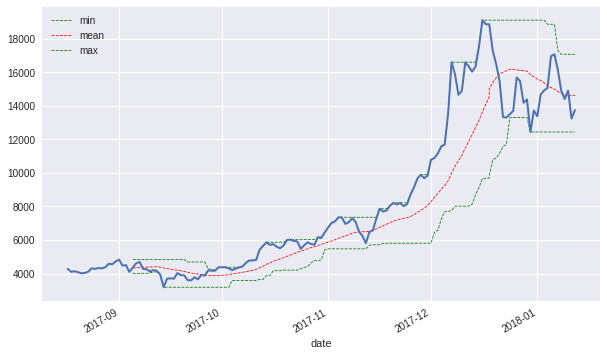

In [260]:
pd.options.plotting.backend='matplotlib' 
ax = df_BTC_close_daily[['min','mean','max']].iloc[:150].plot(figsize=(10,6),style=['g--','r--','g--'],lw=0.8)
df_BTC_close_daily['close'].iloc[:150].plot(ax=ax, lw=2.0)

In [273]:
df_BTC_USD_daily['USD_avg_tradesize'] = df_BTC_USD_daily['Volume USDT'] / df_BTC_USD_daily['tradecount']

df_BTC_close_trades_daily = pd.DataFrame(df_BTC_USD_daily[['close','tradecount','USD_avg_tradesize']])
plyo.iplot(
    df_BTC_close_trades_daily.iplot(asFigure=True,
    subplots=True)
)

Trades seem to correlate with volume, could test that. Is that like liquidity re the tel aviv market study? What about the average trade size, that seems to have increased too.

<AxesSubplot:xlabel='date'>

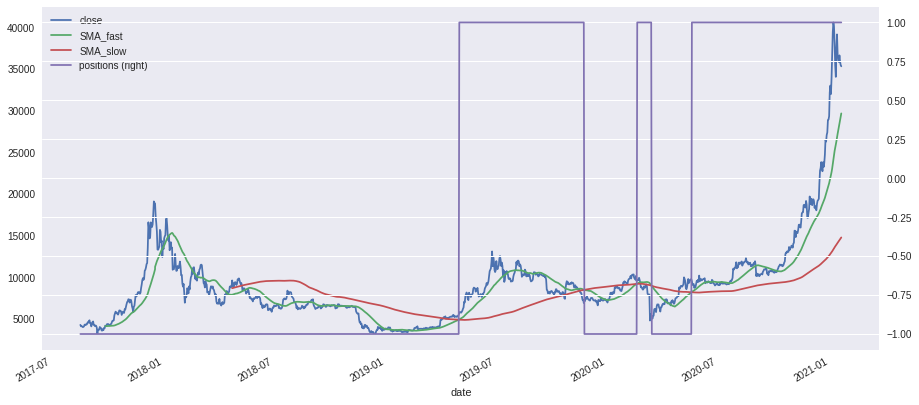

In [289]:
df_BTC_close_daily.sort_index(axis=0 ,ascending=True, inplace=True)
df_BTC_close_daily['SMA_fast'] = df_BTC_close_daily['close'].rolling(window=42).mean()
df_BTC_close_daily['SMA_slow'] = df_BTC_close_daily['close'].rolling(window=252).mean()
df_BTC_close_daily['positions'] = np.where(df_BTC_close_daily['SMA_fast'] > df_BTC_close_daily['SMA_slow'],1,-1)
df_BTC_close_daily[['close','SMA_fast','SMA_slow','positions']].plot(figsize=(15,7), secondary_y='positions', grid=False)


In [290]:
# Rolling correlation between BTC and ETH, then ADA then TRON.

In [251]:
df_BTC_USD_hourly = pd.read_csv('crypto_data/Binance_BTCUSDT_1h.csv', skiprows=0, index_col=1, parse_dates=True)

In [140]:
df_BTC_USD_hourly.head()

,unix,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
date,,,,,,,,,
2021-01-21 00:00:00,1.611187e+12,BTC/USDT,35468.23,35600.00,35338.16,35340.70,248.863628,8.829792e+06,8456.0
2021-01-20 23:00:00,1.611184e+12,BTC/USDT,34955.94,35670.00,34798.39,35468.23,3448.600995,1.221199e+08,84665.0
2021-01-20 22:00:00,1.611180e+12,BTC/USDT,34892.90,35100.00,34748.09,34954.86,1119.622182,3.915307e+07,47851.0
2021-01-20 21:00:00,1.611176e+12,BTC/USDT,34957.15,35110.82,34482.75,34892.89,2130.648407,7.405330e+07,61510.0
2021-01-20 20:00:00,1.611173e+12,BTC/USDT,35197.12,35318.39,34734.97,34957.15,1987.730256,6.962113e+07,74431.0


In [141]:
df_BTC_USD_hourly.isna().sum() # TODO: why are there lots of tradecounts missing

unix               0
symbol             0
open               0
high               0
low                0
close              0
Volume BTC         0
Volume USDT        0
tradecount     28584
dtype: int64

In [142]:
df_BTC_USD_hourly.describe()

,unix,open,high,low,close,Volume BTC,Volume USDT,tradecount
count,3.270900e+04,32709.00000,32709.000000,32709.000000,32709.000000,32709.000000,3.270900e+04,4125.000000
mean,2.036106e+11,9220.73298,9275.087849,9161.049287,9221.619803,1870.924915,2.000140e+07,51975.029333
std,5.319001e+11,4915.65155,4962.209419,4862.305737,4917.979817,1999.984415,3.207474e+07,35459.751999
min,1.502942e+09,2919.00000,2950.000000,2817.000000,2919.000000,0.000000,0.000000e+00,0.000000
25%,1.532394e+09,6494.99000,6519.000000,6471.120000,6494.990000,805.420000,5.746229e+06,28403.000000
50%,1.561831e+09,8570.88000,8629.310000,8520.580000,8570.880000,1365.510000,1.128950e+07,41876.000000
75%,1.591268e+09,10715.91000,10757.930000,10664.630000,10715.910000,2267.190000,2.163189e+07,64950.000000
max,1.611187e+12,41454.13000,41950.000000,40970.220000,41454.130000,47255.760000,7.548817e+08,352801.000000


In [143]:
df_olhc_hourly = df_BTC_USD_hourly[['open','high','low','close']]

In [144]:
qf_hourly = cf.QuantFig(
    df_olhc_hourly.iloc[:50],
    title='BTC/USD Exchange Rate - Hourly',
    legend='top',
    name='BTC/USD'
)

In [145]:
plyo.iplot(
    qf_hourly.iplot(asFigure=True),
    #image='png',
    #filename='btc_01'
)